In [1]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [7]:
# Libraries
# ==============================================================================
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Autoregressive forecaster

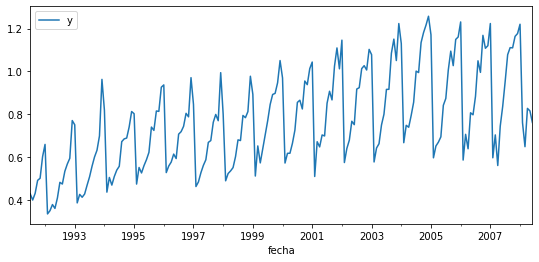

In [8]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
ax.legend();

In [9]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor=LinearRegression(),
                    lags=15
                )

forecaster.fit(y=datos_train)
forecaster

=======================ForecasterAutoreg=======================
Regressor: LinearRegression()
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Window size: 15
Exogenous variable: False, None
Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

Test error (mse): 0.011051937043503714


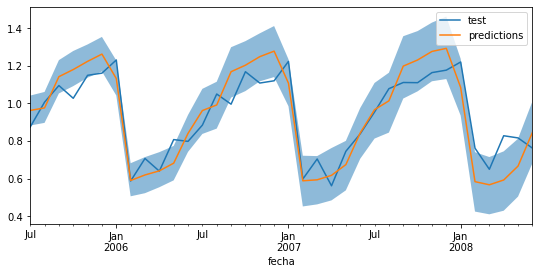

In [10]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [5, 95],
                    n_boot   = 1000, 
                    in_sample_residuals = True
              )

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

In [11]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                        (datos_test >= predictions.iloc[:, 1]) \
                        & (datos_test <= predictions.iloc[:, 2]),
                        True,
                        False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {100 * cobertura}")

Cobertura del intervalo predicho: 69.44444444444444


[0.02150972]


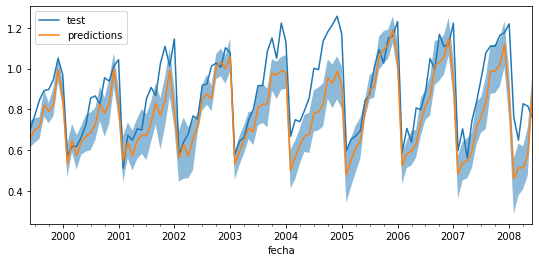

In [14]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=15)

metrica, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True
                       )

print(metrica)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

In [16]:
forecaster.fit(y=datos_train)
predictions_1 = forecaster.predict_interval(steps=steps)
print(len(predictions_1.iloc[:, 0]), predictions_1.iloc[:, 0])
print("")
predictions_2 = forecaster.predict_interval(steps=steps, last_window=datos_test[:steps])
print(len(predictions_2.iloc[:, 0]), predictions_2.iloc[:, 0])
print("")
predictions_3 = forecaster.predict_interval(steps=steps, last_window=datos_test[steps:steps*2])
print(len(predictions_3.iloc[:, 0]), predictions_3.iloc[:, 0])
print("")
predictions_4 = forecaster.predict_interval(steps=1, last_window=datos_test[steps*2:steps*3])
print(len(predictions_4.iloc[:, 0]), predictions_4.iloc[:, 0])
print("")
(predictions.iloc[:, 0] == np.concatenate([predictions_1.iloc[:, 0], predictions_2.iloc[:, 0], predictions_3.iloc[:, 0], predictions_4.iloc[:, 0]])).all()

36 1999-06-01    0.659751
1999-07-01    0.700833
1999-08-01    0.713227
1999-09-01    0.821183
1999-10-01    0.790163
1999-11-01    0.824298
1999-12-01    0.994785
2000-01-01    0.856393
2000-02-01    0.532397
2000-03-01    0.646115
2000-04-01    0.574033
2000-05-01    0.641750
2000-06-01    0.669253
2000-07-01    0.684950
2000-08-01    0.724211
2000-09-01    0.826359
2000-10-01    0.780580
2000-11-01    0.830909
2000-12-01    0.996985
2001-01-01    0.820639
2001-02-01    0.547348
2001-03-01    0.636891
2001-04-01    0.571790
2001-05-01    0.647009
2001-06-01    0.673653
2001-07-01    0.671693
2001-08-01    0.736579
2001-09-01    0.829216
2001-10-01    0.771740
2001-11-01    0.841276
2001-12-01    0.993268
2002-01-01    0.790895
2002-02-01    0.561616
2002-03-01    0.627567
2002-04-01    0.570481
2002-05-01    0.655083
Freq: MS, Name: pred, dtype: float64

36 2002-06-01    0.717996
2002-07-01    0.853388
2002-08-01    0.875471
2002-09-01    0.850510
2002-10-01    1.007050
2002-11-01   

True

In [18]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                        (datos_test >= predictions.iloc[:, 1]) \
                        & (datos_test <= predictions.iloc[:, 2]),
                        True,
                        False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {100 * cobertura}")

Cobertura del intervalo predicho: 45.87155963302752


## Autoreg + 1 exogenous predictor
<br>

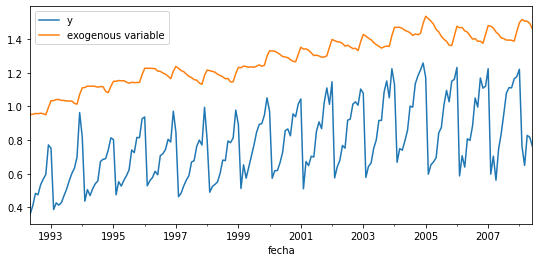

In [19]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variable
# ==============================================================================
datos_exog = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog = datos_exog[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog.plot(ax=ax, label='exogenous variable')
ax.legend();


# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

Test error (mse): 0.020306077140235624


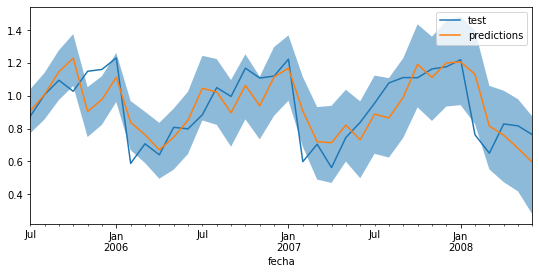

In [20]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    exog     = datos_exog_test,
                    interval = [5, 95],
                    n_boot   = 500
              )


# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

In [22]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=8)

metrica, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True
                       )

print(metrica)

[0.01325921]


## Autoregressive + n exogenous predictors
<br>

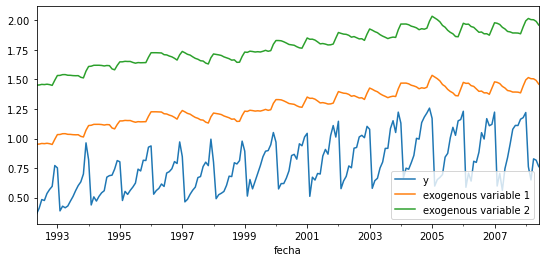

In [16]:
# Download data
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
      + 'Estadistica-machine-learning-python/master/data/h2o.csv'
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variables
# ==============================================================================
datos_exog_1 = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog_2 = datos.rolling(window=10, closed='right').mean() + 1
datos_exog_1 = datos_exog_1[10:]
datos_exog_2 = datos_exog_2[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog_1.plot(ax=ax, label='exogenous variable 1')
datos_exog_2.plot(ax=ax, label='exogenous variable 2')
ax.legend();

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog = np.column_stack((datos_exog_1.values, datos_exog_2.values))
datos_exog_train = datos_exog[:-steps,]
datos_exog_test  = datos_exog[-steps:,]

In [23]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    exog     = datos_exog_test,
                    interval = [5, 95],
                    n_boot   = 500
              )

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

ValueError: Found input variables with inconsistent numbers of samples: [109, 36]

In [25]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=8)

metrica, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True
                       )

print(metrica)

[0.01325921]


## Intervalos estimados con residuos out-of-sample

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


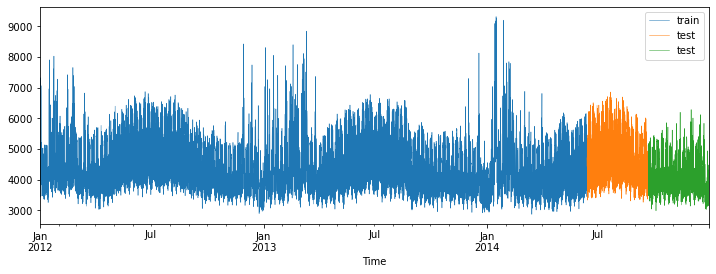

In [19]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/vic_elec.csv'
datos = pd.read_csv(url, sep=',')
datos.info()

# Conversión del formato fecha
# ==============================================================================
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos = datos.set_index('Time')
datos = datos.asfreq('30min')
datos = datos.sort_index()

# Agregado en intervalos de 1H
# ==============================================================================
# Se elimina la columna Date para que no genere error al agregar. La columna Holiday
# no genera error ya que es booleana y se trata como 0-1.
datos = datos.drop(columns='Date')
datos = datos.resample(rule='H', closed='left', label ='right').mean()
datos

# Separación datos train-validation-test
# ==============================================================================
dias_test = 100
dias_validacion = 100
datos = datos.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
fecha_fin_train   = datos.index[-1] - pd.Timedelta(dias_validacion + dias_test, unit='D')
fecha_inicio_validacion = fecha_fin_train + pd.Timedelta(1, unit='H')
fecha_fin_validacion    = fecha_inicio_validacion + pd.Timedelta(dias_validacion, unit='D')
fecha_inicio_test = fecha_fin_validacion + pd.Timedelta(1, unit='H')

datos_train       = datos.loc[: fecha_fin_train, :]
datos_validacion  = datos.loc[fecha_inicio_validacion:fecha_fin_validacion, :]
datos_test        = datos.loc[fecha_inicio_test:, :]

# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
datos_train.Demand.plot(ax=ax, label='train', linewidth=0.5)
datos_validacion.Demand.plot(ax=ax, label='test', linewidth=0.5)
datos_test.Demand.plot(ax=ax, label='test', linewidth=0.5)
ax.legend();

In [20]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(normalize=True),
                lags      = 24
             )

forecaster.fit(y=datos_train.Demand)
forecaster

=======================ForecasterAutoreg=======================
Regressor: Ridge(normalize=True)
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Exogenous variable: False
Parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': True, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

In [21]:
# Backtest conjunto validación
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos.Demand.loc[:fecha_fin_validacion],
                            initial_train_size = len(datos_train.Demand),
                            steps      = 24,
                            metric     = 'mean_absolute_error'
                        )

Se calculan los errores de validación para utilizarlos como *out-sample-residuals* en la estimación de intervalos de predicción.

In [22]:
forecaster.out_sample_residuals = datos_validacion.Demand - predicciones

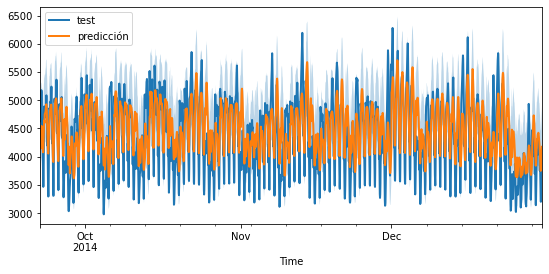

In [23]:
# Backtest con intervalos de predicción para el conjunto de test
# ==============================================================================
metrica, predicciones = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos.Demand,
                            initial_train_size = len(datos_train.Demand) + len(datos_validacion.Demand),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            interval            = [5, 95],
                            n_boot              = 1000,
                            in_sample_residuals = False
                        )

# Se añade el índice temporal a las predicciones
predicciones = pd.DataFrame(data=predicciones, index=datos_test.index)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.loc[predicciones.index, 'Demand'].plot(ax=ax, linewidth=2, label='test')
predicciones.iloc[:, 0].plot(linewidth=2, label='predicción', ax=ax)
ax.fill_between(predicciones.index,
                predicciones.iloc[:, 1],
                predicciones.iloc[:, 2],
                alpha=0.3)
ax.legend();

In [24]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                        (datos_test.Demand >= predicciones.iloc[:, 1]) \
                        & (datos_test.Demand <= predicciones.iloc[:, 2]),
                        True,
                        False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {100 * cobertura}")

Cobertura del intervalo predicho: 80.03334722801168


El intervalo no consigue la cobertura esperada del 90%

## Información de sesión

In [25]:
from sinfo import sinfo
sinfo()

-----
matplotlib  3.3.2
numpy       1.19.5
pandas      1.2.3
sinfo       0.3.1
skforecast  0.1.7
sklearn     0.24.1
tqdm        4.59.0
-----
IPython             7.20.0
jupyter_client      6.1.11
jupyter_core        4.7.1
notebook            6.2.0
-----
Python 3.7.9 (default, Aug 31 2020, 12:42:55) [GCC 7.3.0]
Linux-5.4.0-1041-aws-x86_64-with-debian-buster-sid
2 logical CPU cores, x86_64
-----
Session information updated at 2021-03-30 15:12
